In [1]:
import numpy as np
from ticktack import fitting
import ticktack
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import jax.numpy as jnp
import matplotlib as mpl
import matplotlib.font_manager as font_manager
from matplotlib.lines import Line2D
mpl.style.use('seaborn-colorblind')

In [2]:
model = "Brehm21"
cbm = ticktack.load_presaved_model(model, production_rate_units='atoms/cm^2/s')
sf1 = fitting.SingleFitter(cbm, model, box="Troposphere", hemisphere='north')
sf1.compile_production_model(model="flexible_sinusoid_affine_variant")
sf1.load_data("recover_NH.csv", oversample=1008, burnin_time=2000)
sf1.box_idx, sf1.growth

(12,
 DeviceArray([0., 0., 0., 1., 1., 1., 1., 1., 1., 0., 0., 0.], dtype=float64))

In [3]:
model = "Brehm21"
cbm = ticktack.load_presaved_model(model, production_rate_units='atoms/cm^2/s')
sf2 = fitting.SingleFitter(cbm, model, box="Troposphere", hemisphere='south')
sf2.compile_production_model(model="flexible_sinusoid_affine_variant")
sf2.load_data("recover_SH.csv", oversample=1008, burnin_time=2000)
sf2.box_idx, sf2.growth

(1,
 DeviceArray([1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1.], dtype=float64))

In [4]:
params = np.array([-2.20263609e-03,  210,  2.55367316e-01,  3.28980240e+00,
        8.21112436e-01, -1.38787353e+00])

In [5]:
default_params = jnp.array([-1.00797052e-03,  2.10523473e+02, -3.35300358e-01,  3.85064256e+00,
        7.87839120e-01, -1.61086280e+00])
default_low_bounds = jnp.array([-1.76 * 0.05 / 5, 210 - 5, np.log10(4 / 52.), 0, -2, -2])
default_up_bounds = jnp.array([1.76 * 0.05 / 5, 210 + 5, np.log10(5.), 11, 1.5, 1.5])

In [6]:
mf = fitting.MultiFitter()
mf.add_SingleFitter(sf1)
mf.add_SingleFitter(sf2)
mf.compile()

In [7]:
chain = mf.MarkovChainSampler(params,
                                          likelihood=mf.log_joint_likelihood,
                                          burnin=1000,
                                          production=1000,
                                          args=(default_low_bounds, default_up_bounds)
                                          )

Running burn-in...


100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [06:59<00:00,  2.38it/s]


Running production...


100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [06:52<00:00,  2.42it/s]


In [8]:
np.mean(chain, axis=0)

array([-2.29820201e-03,  2.10217255e+02,  9.91920012e-02,  3.43111494e+00,
        8.01723030e-01, -1.65826865e+00])

In [9]:
params_truth = np.array([-2.20263609e-03,  210-205,  10**2.55367316e-01, 
                         10**8.21112436e-01/1.76, 3.28980240e+00, 10**-1.38787353e+00])

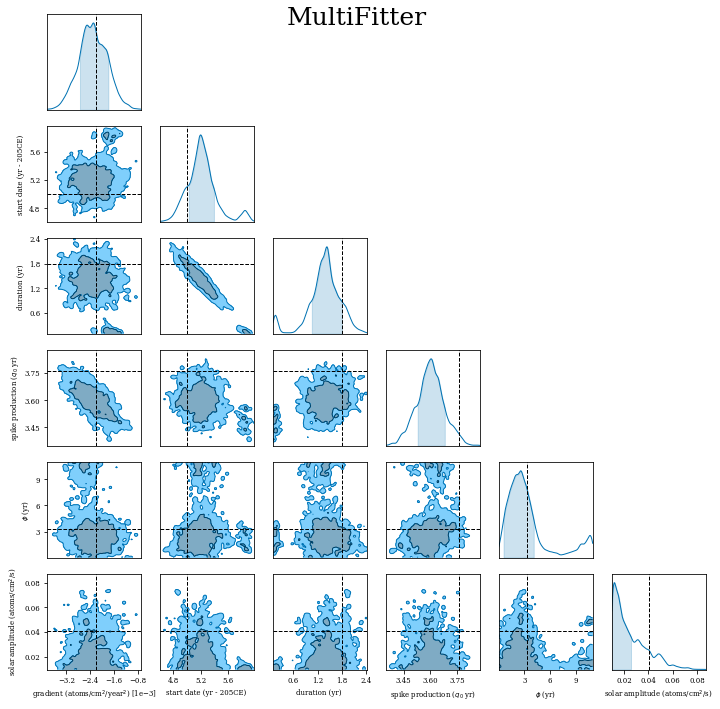

In [10]:
chain_copy = np.copy(chain)
start_date = "start date ({})".format("yr - " + str(int(210) - 5) + "CE")

chains = []
chains.append(chain_copy);

labels = ["gradient (atoms/cm$^2$/year$^2$)", start_date, "duration (yr)", "spike production ($q_0$ yr)", "$\phi$ (yr)", "solar amplitude (atoms/cm$^2$/s)"]
idx = 1
spike_idx  = 4
for i in range(len(chains)):
    chains[i][:, 2] = 10**chains[i][:, 2]
    chains[i][:, -1] = 10 ** chains[i][:, -1]
    chains[i][:, -2] = 10 ** chains[i][:, -2] / 1.76


for c in chains:
    c[:, idx] = c[:, idx] - (210 - 5)
    spike = c.copy()[:, spike_idx]
    c[:, spike_idx] = c[:, spike_idx - 1]
    c[:, spike_idx - 1] = spike

colors = mpl.rcParams['axes.prop_cycle'].by_key()['color']
cf = fitting.CarbonFitter()
fig = cf.plot_multiple_chains(chains, chain.shape[1] * 2,
                        params_labels=labels,
                        label_font_size=7,
                        tick_font_size=7, colors=colors, max_ticks=4, legend=False, truth=params_truth
                        )

font = font_manager.FontProperties(family='serif', size=14)
# custom_lines = [Line2D([0], [0], color=colors[i], lw=0, label=["NH", "SH"][i]) for i in range(len(["NH", "SH"]))]
ax = fig.get_axes()[5]
# legend = ax.legend(handles=custom_lines, frameon=False, labelcolor=colors,
#                    prop=font, loc="upper right", bbox_to_anchor=(1, 0.5))
plt.suptitle("MultiFitter", fontsize=25)
fig.savefig("multi.jpg")

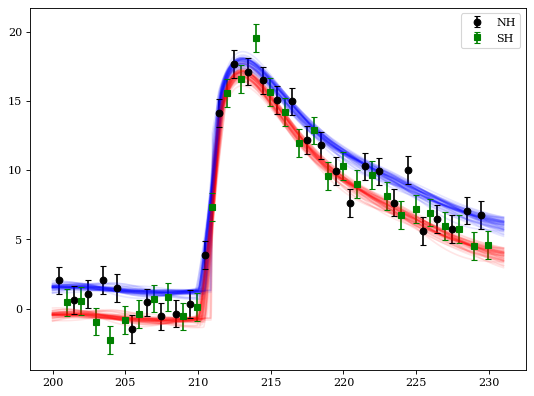

In [22]:
idx = np.random.randint(len(chain), size=50)
plt.figure(figsize=(8, 6), dpi=80)
for i in idx:
    plt.plot(sf1.time_data_fine, sf1.dc14_fine(chain[i]), "b", alpha=0.1)
    plt.plot(sf2.time_data_fine, sf2.dc14_fine(chain[i]), "r", alpha=0.1)

plt.errorbar(sf1.time_data + sf1.time_offset, sf1.d14c_data, yerr=sf1.d14c_data_error, fmt="ok", capsize=3, label="NH")
plt.errorbar(sf2.time_data + sf2.time_offset, sf2.d14c_data, yerr=sf2.d14c_data_error, fmt="sg", capsize=3, label="SH")
plt.legend()